# 1. 패키지 import, 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

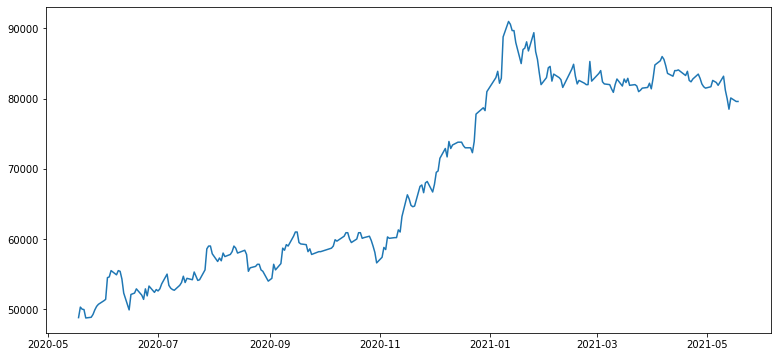

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 2. 전처리 수행

### 1) null 제거

In [3]:
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

보간법으로 해당 결측치 처리

In [4]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 2) log변환

In [5]:
ts_log=np.log(ts)

# 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(time Series Decomposition)
- Residual 안정성 확인

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

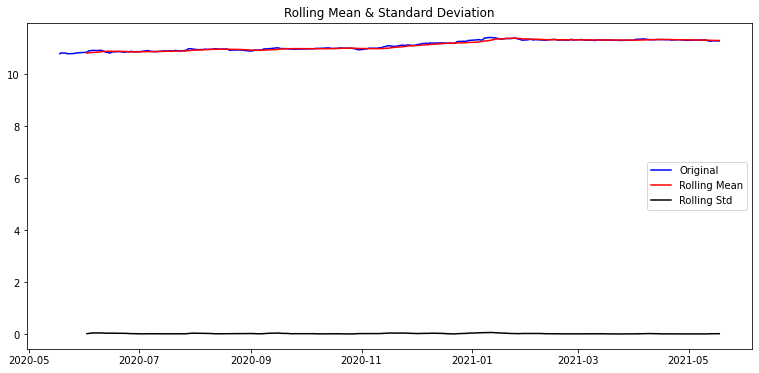

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


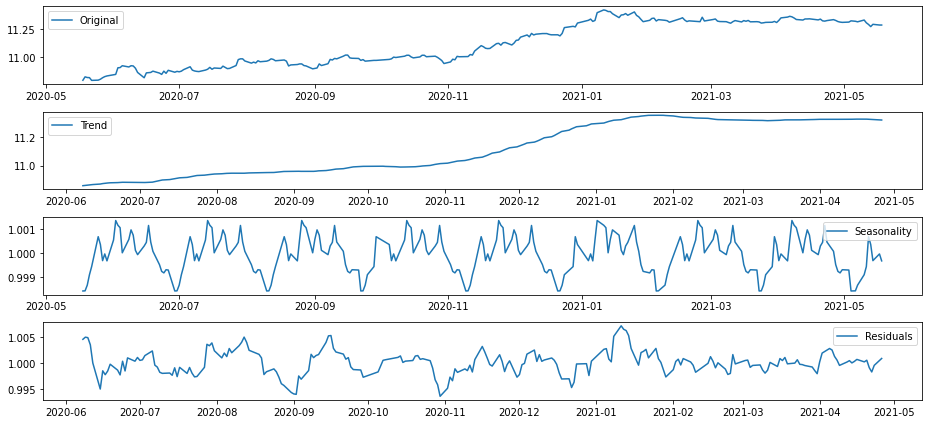

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 약 0.6으로 나왔다. 뭔가 이상하다

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


나는 숫자에 e가 나오면 바보가 된다 그래서 p-value값이 어떤 수준인지 모르겠다.    
**to. 이 플젝을 보실 퍼실님께**  
나중에 게더에서 everyone으로 위에 있는 p-value값이 얼마인지 알려주시면 땡큐베리감사입니다~!~!

# 4. 데이터셋 나누기
train : test = 9 : 1

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

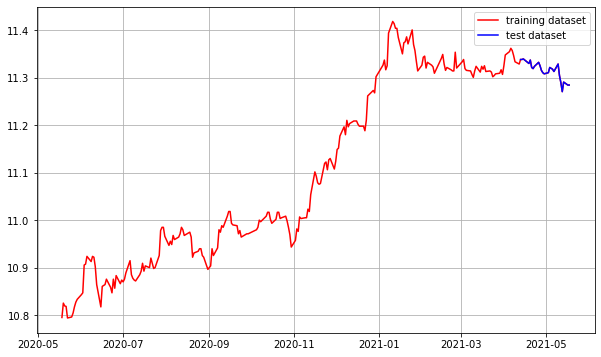

In [11]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

data shape 확인하기

In [12]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


# 5. 적정 ARIMA p, q, d 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


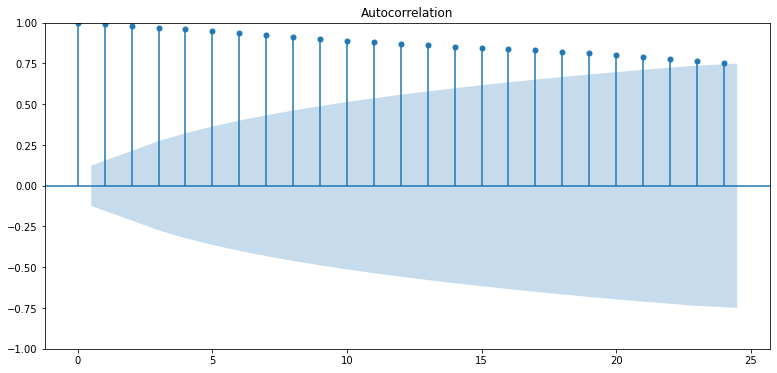

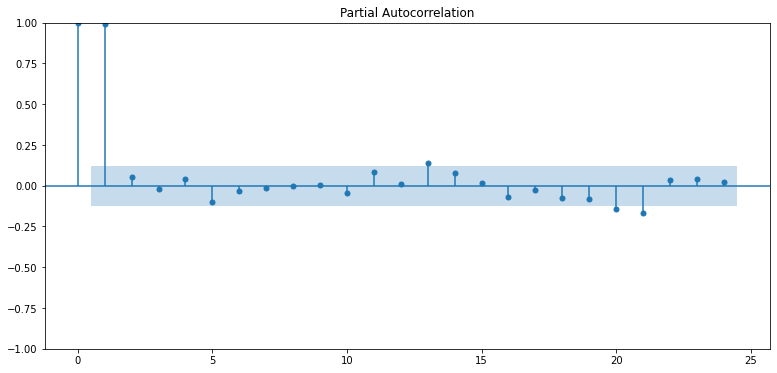

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


p>=2인 구간에서 PACF는 0에 가까워지고 있다. 따라서 p=1로 설정, q는 적당한 값을 찾지 못하겠으므로 0으로 설정한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


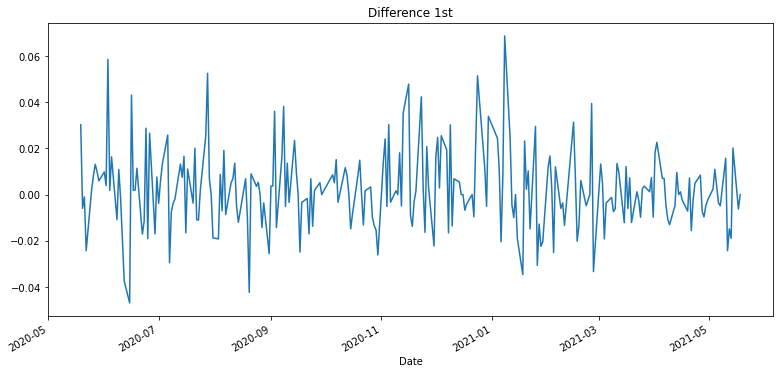

In [14]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


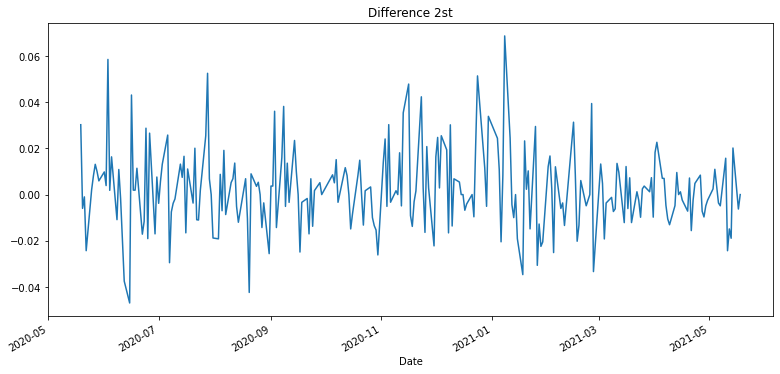

In [15]:
diff_2 = ts_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')
augmented_dickey_fuller_test(diff_2)

두 차분의 큰 차이가 없으므로 d=1로 설정

# 6. ARIMA 모델 훈련 테스트

### 1) ARIMA 모델 빌드 및 훈련

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 10 Feb 2022   AIC                          -1162.976
Time:                        06:39:06   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 2) 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


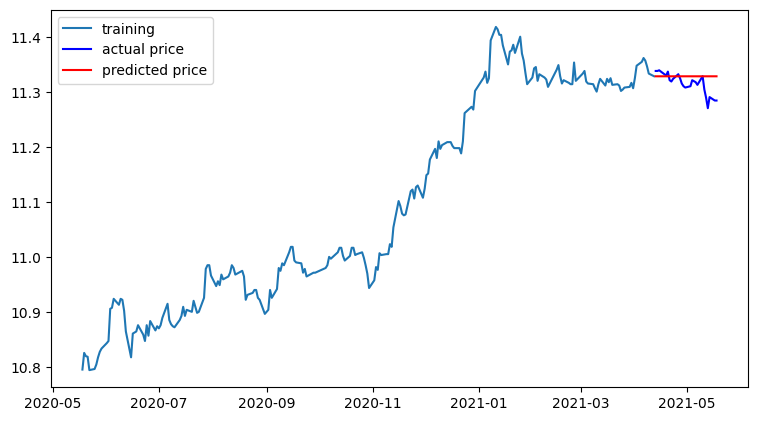

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05) 
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 3) 최종 예측 모델 정확도 측정

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


MAPE = 1.74%로 연산되었다.

# 7. 다른 주식종목 예측해보기

다른 주식을 예측하라고 했지만 이번에는 가상화폐를 예측해보겠다!!!   
선택한 자료는 미국의 비트코인이다.

가상화폐를 선택한 이유   
- 변동성이 매우 큰 자료라는 판단이 들었음
- 변동성이 큼에도 불구하고 규칙성이 있을지 궁금했음    
- 규칙성이 있다면 어떤 시기에 가격이 하락하는지 알아볼 수 있을 것 같다.

In [24]:
!pwd

/aiffel/aiffel/AIFFEL/EXPLORATION/E11stock


In [25]:
!ls

 BTCUSD.csv  '[E11]stock.ipynb'


먼저 사용한 데이터는 2021년 2월 10일~2022년 2월 10일까지의 자료이다.

In [26]:
dataset_filepath = os.getenv('HOME')+'/aiffel/AIFFEL/EXPLORATION/E11stock/BTCUSD.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,44918.183594,87301089896
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,47909.332031,81388911810
2021-02-12,47877.035156,48745.734375,46424.976563,47504.851563,47504.851563,76555041196
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,47105.515625,70250456155
2021-02-14,47114.507813,49487.640625,47114.507813,48717.289063,48717.289063,71248675228


주식의 colum과 같은 colum을 가지고 있다.   
동일한 사이트에서 다운 받은 파일이기 때문에 동일한 양식을 사용한 것 같다.
가상화폐는 주식과 달리 폐장이 없어 Close의 의미가 크지 않을 것 같지만, 00:00~24:00로 개장, 폐장을 가정하고 Close를 사용하겠다.

In [27]:
ts = df['Close']

ts.head()

Date
2021-02-10    44918.183594
2021-02-11    47909.332031
2021-02-12    47504.851563
2021-02-13    47105.515625
2021-02-14    48717.289063
Name: Close, dtype: float64

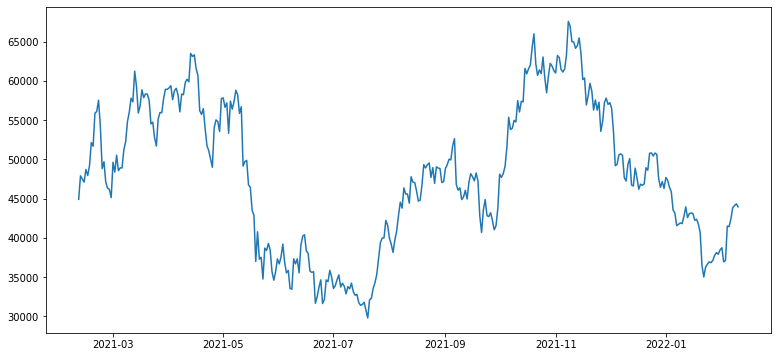

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [29]:
# 결측치 처리
ts=ts.interpolate(method='time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [30]:
# 로그 변환 시도 
ts_log = np.log(ts)

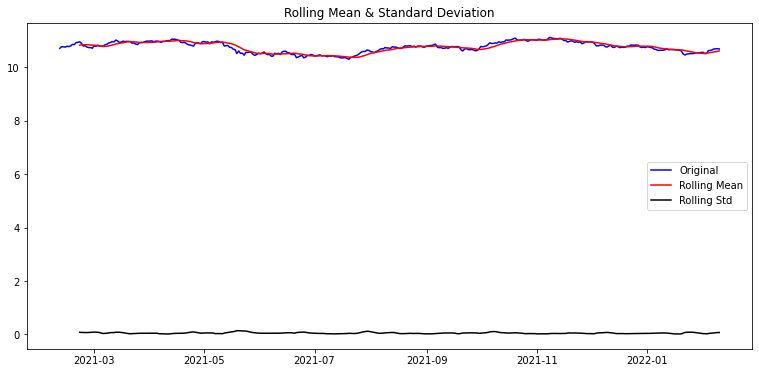

Results of Dickey-Fuller Test:
Test Statistic                  -1.879644
p-value                          0.341697
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


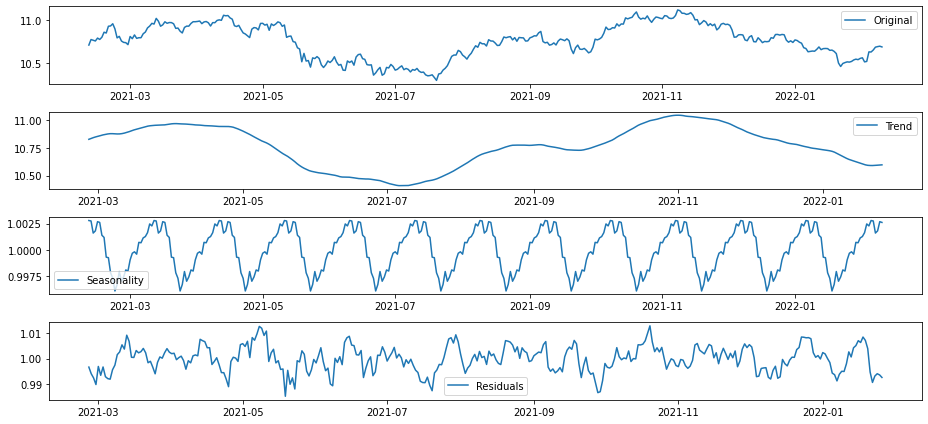

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 삼성전자의 자료보다 더 낮게 나왔다. 물론 약0.34의 값으로 안정적이다 말할 수 없지만. 주식 자료보다 안정적이라는 것에 의의를 둔다.

### 데이터셋 나누기

In [36]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

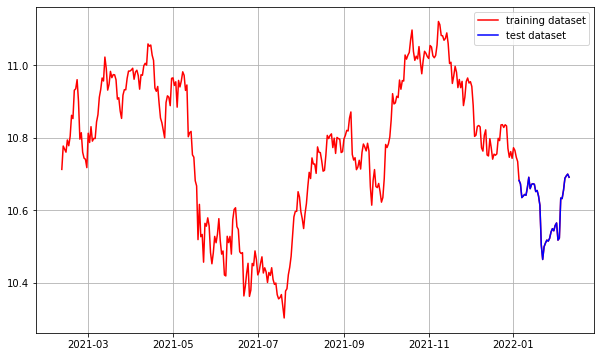

In [37]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [38]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    10.712598
2021-02-11    10.777066
Name: Close, dtype: float64
(329,)
(37,)


### ARIMA p, d,  q 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


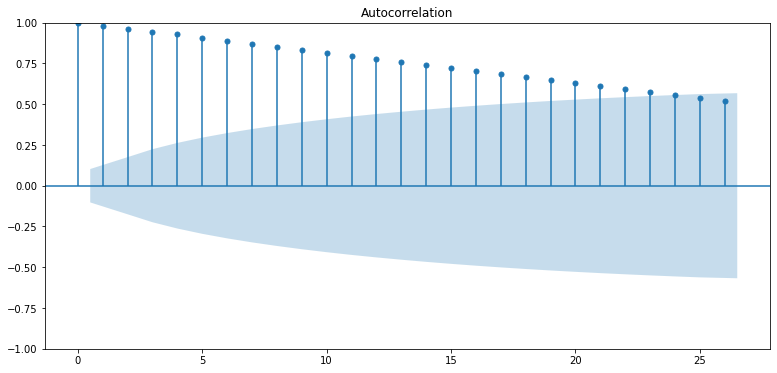

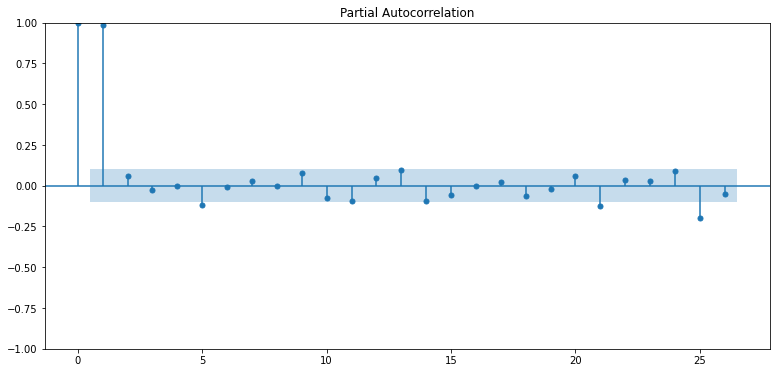

In [39]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.200871
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


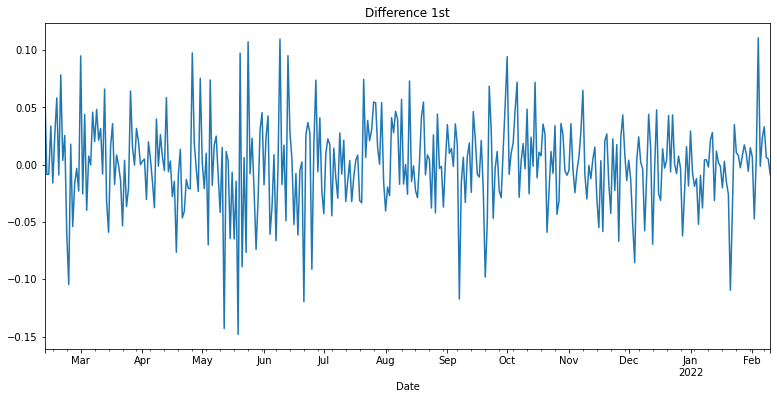

In [40]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                 -20.200871
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


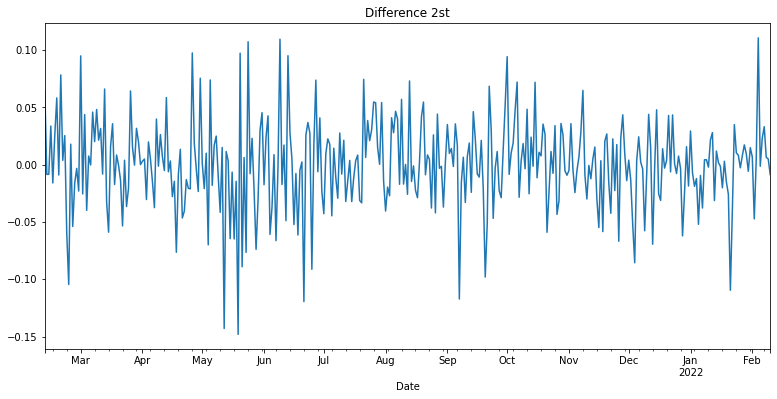

In [41]:
diff_2 = ts_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')
augmented_dickey_fuller_test(diff_2)

q = 0, d = 1, p = 1로 설정   
삼성전자 주식과 동일한 이유로 설정하게 됨

### 모델 빌드 및 훈련

In [42]:
model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 595.242
Date:                Thu, 10 Feb 2022   AIC                          -1186.484
Time:                        07:01:52   BIC                          -1178.898
Sample:                    02-10-2021   HQIC                         -1183.457
                         - 01-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0766      0.057     -1.332      0.183      -0.189       0.036
sigma2         0.0016   9.69e-05     16.032      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


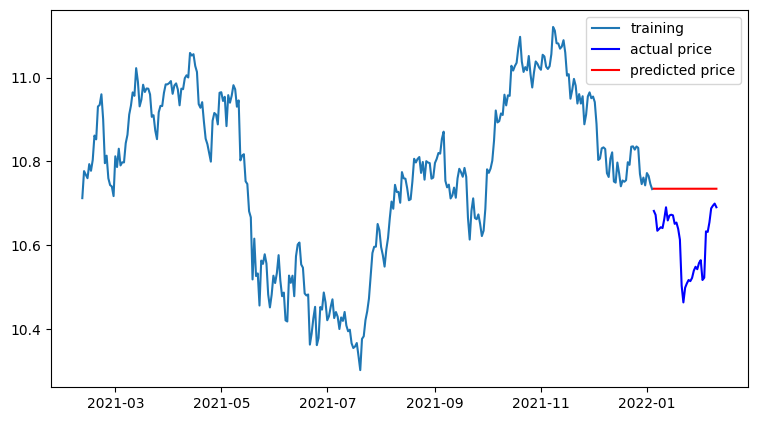

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05) 
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [44]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  36651729.4315395
MAE:  5353.034909630668
RMSE:  6054.067180956906
MAPE: 13.76%


MAPE가 13.76%가 나왔다. 모델을 개선하는 것도 필요하겠지만 이러한 분석 방법에는 가상화폐가 적합하지 않은 것 같다.   
잘 정제되어 있는 데이터임에도 다소 높은 오차율이 나오는 것은 주식보다 더 많이, 크게 상승과 하락을 지속하기 때문인 것 같다.   
더군다나 2021년은 비트코인 급락과 급등이 잦았던 해로 알고 있어 더 예측이 안되는 것 같다.

## MAX period Bitcoin csv

이번에는 야후 경제 홈페이지 기준 기간을 MAX로 설정하여 csv로 구성한 비트코인 시세로 실험을 해보겠다.

In [45]:
dataset_filepath = os.getenv('HOME')+'/aiffel/AIFFEL/EXPLORATION/E11stock/BTCUSDM.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


1 BTC가 500달러도 안되는 시가라니 ,,,, 저 때 샀어야 했다

In [46]:
ts = df['Close']

ts.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

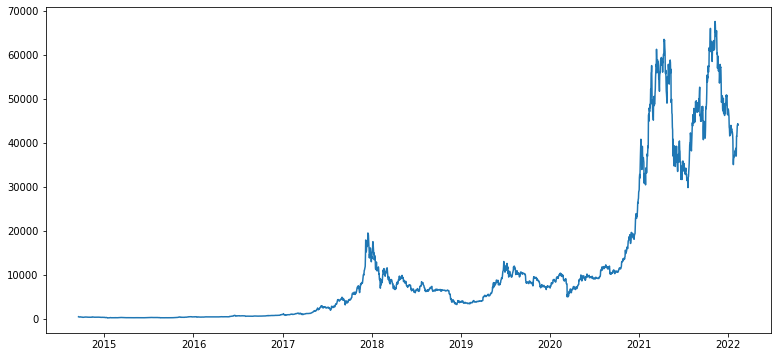

In [47]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

### 데이터 정제

In [48]:
# 결측치 처리
ts=ts.interpolate(method='time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [49]:
# 로그 변환 시도 
ts_log = np.log(ts)

### stationary

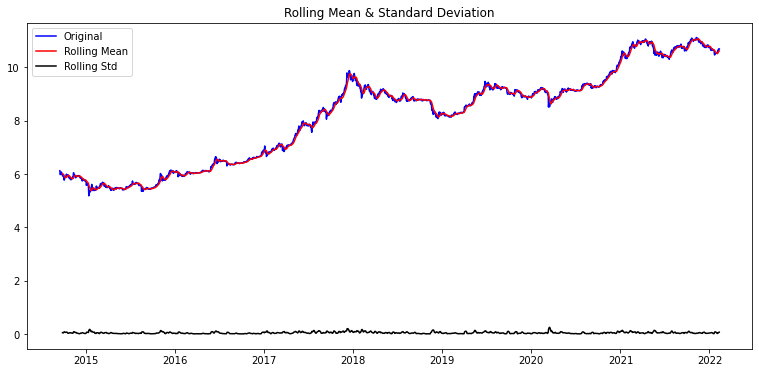

Results of Dickey-Fuller Test:
Test Statistic                   -0.413137
p-value                           0.907882
#Lags Used                       10.000000
Number of Observations Used    2693.000000
Critical Value (1%)              -3.432781
Critical Value (5%)              -2.862614
Critical Value (10%)             -2.567342
dtype: float64


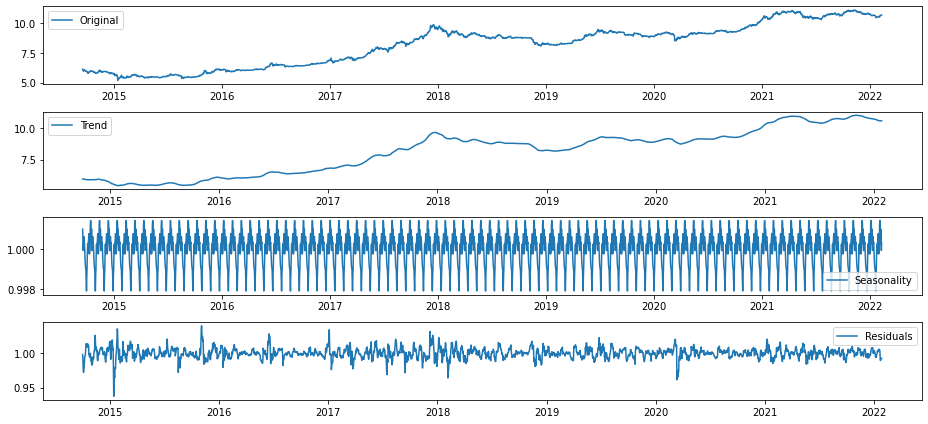

In [50]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

p-value가 0.9로 나오는 데이터를 찾았다.. ! 노다지!!

In [51]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.356735e+01
p-value                        2.249352e-25
#Lags Used                     2.800000e+01
Number of Observations Used    2.645000e+03
Critical Value (1%)           -3.432825e+00
Critical Value (5%)           -2.862633e+00
Critical Value (10%)          -2.567352e+00
dtype: float64


### 데이터셋 나누기

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

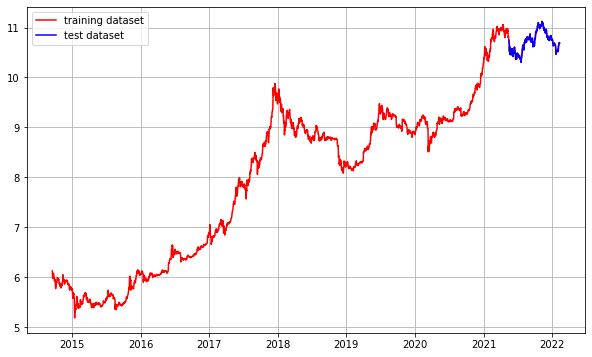

In [53]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [54]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2014-09-17    6.125414
2014-09-18    6.050771
Name: Close, dtype: float64
(2433,)
(271,)


### ARIMA 적정 파라미터 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


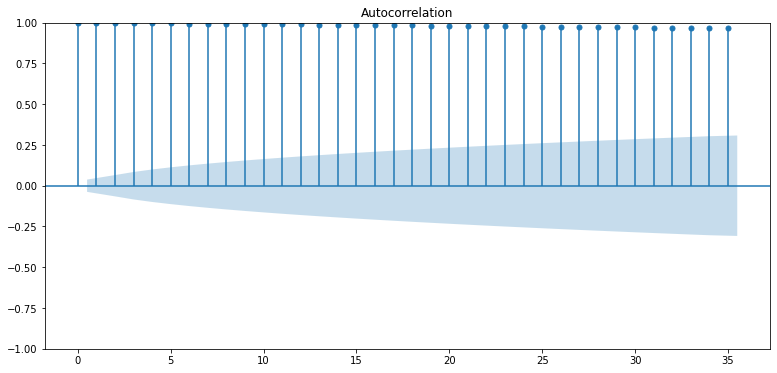

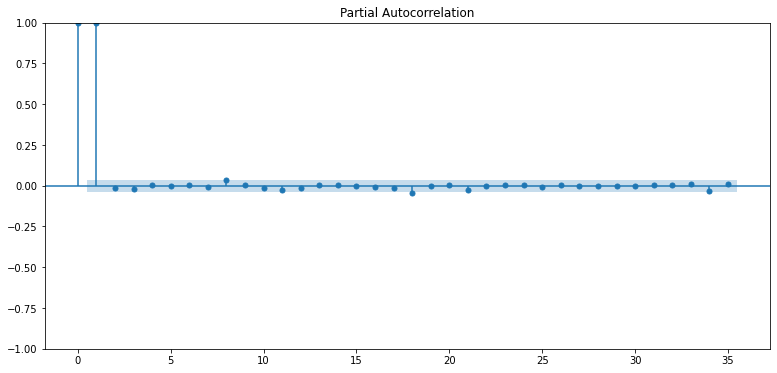

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.562250e+01
p-value                        1.724894e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.693000e+03
Critical Value (1%)           -3.432781e+00
Critical Value (5%)           -2.862614e+00
Critical Value (10%)          -2.567342e+00
dtype: float64


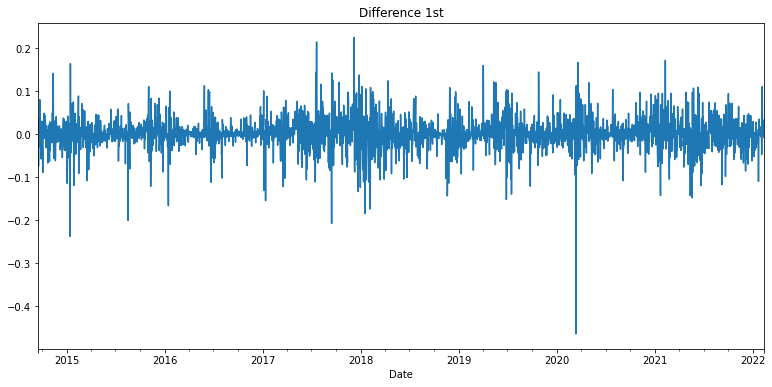

In [56]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.562250e+01
p-value                        1.724894e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.693000e+03
Critical Value (1%)           -3.432781e+00
Critical Value (5%)           -2.862614e+00
Critical Value (10%)          -2.567342e+00
dtype: float64


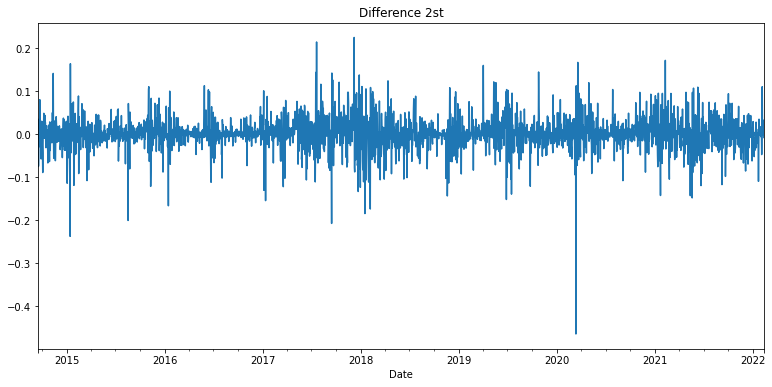

In [57]:
diff_2 = ts_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')
augmented_dickey_fuller_test(diff_2)

앞서 수행한 비트코인 파라미터와 동일하게 진행

### 훈련

In [64]:
model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


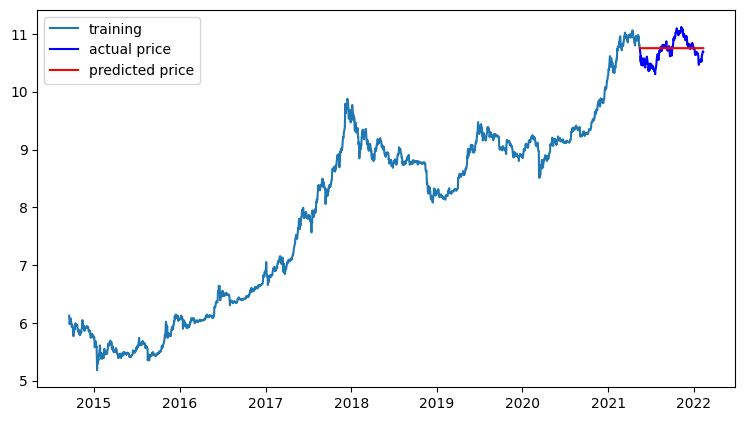

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05) 
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  86940850.9922724
MAE:  7640.019545467824
RMSE:  9324.207794352955
MAPE: 17.65%


에러 값이 더 늘어난다..!

-------------------------------------------------------------------------------------------------------------

# 회고

- goingDeeper에 ARIMA 모델 다시 나온다고 하는데 벌써부터 아찔하다
- 시계열 데이터를 어떻게 정제하고 어느 모델로 훈련시키는지 느낌만 알아가자
- 노드 저자는 굉장히 친절하게 설명했지만 나의 머리가 따라가지 못한 기분이라 약간 미안한 마음이 들었다    
- 통계학과, 빅데이터학과 정말 대단한다.    